In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
import scipy as sp
#%matplotlib inline
%matplotlib notebook
sns.set()
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import arff
import scipy.io.arff as si
import datetime

In [2]:
#data files
os.listdir("../data/home/share/data/public_sets/WISDM_at_v2.0/")

['.WISDM_at_v2.0_raw_about.txt.swp',
 'readme.txt',
 'WISDM_at_v2.0_demographics.txt',
 'WISDM_at_v2.0_demographics_about.txt',
 'WISDM_at_v2.0_raw.txt',
 'WISDM_at_v2.0_raw_about.txt',
 'WISDM_at_v2.0_transformed.arff',
 'WISDM_at_v2.0_transformed_about.txt',
 'WISDM_at_v2.0_unlabeled_raw.txt',
 'WISDM_at_v2.0_unlabeled_raw_about.txt',
 'WISDM_at_v2.0_unlabeled_transformed.arff',
 'WISDM_at_v2.0_unlabeled_transformed_about.txt']

In [3]:
#demographics data
base = "../data/home/share/data/public_sets/WISDM_at_v2.0/"
demog = pd.read_csv(base+"WISDM_at_v2.0_demographics.txt",
                    names=["user", "height", "sex", "age", "weight", "leg_injury"])

#leg_injury - indicator if user has leg injury (0 for none, 1 if has)
demog.head()

user  height sex   age  weight  leg_injury
0     1    62.5   F  21.0   135.0         0.0
1     2    68.0   F  20.0   160.0         0.0
2     3    79.0   M  19.0   180.0         0.0
3     4    73.0   M  21.0   165.0         1.0
4     5    66.5   M  22.0   125.0         0.0

In [24]:
#raw data 
raw = pd.read_csv(base+'WISDM_at_v2.0_raw.txt', sep=",",
                  names=["user", "activity", "timestamp", "x", "y", "z"],
                  low_memory=False).dropna()
raw.drop([409831, 779331, 779332], inplace=True) #timestamps are indecipherable
raw["timestamp"] = pd.to_datetime(raw["timestamp"], unit="ms")
raw.reset_index(drop=True, inplace=True)
raw["z"] = raw["z"].apply(lambda x: float(x[:-1]))

In [34]:
#separate the time and date
raw["date"] = raw["timestamp"].apply(lambda x: x.date())
raw["time"] = raw["timestamp"].apply(lambda x: x.time())

In [60]:
raw.head()

user activity               timestamp         x         y         z  \
0  1679  Walking 2013-06-06 12:07:49.556  0.294132 -0.635605 -0.226936   
1  1679  Walking 2013-06-06 12:07:49.606 -0.499688 -0.604451 -0.226020   
2  1679  Walking 2013-06-06 12:07:49.656 -2.178345  0.713491  0.372017   
3  1679  Walking 2013-06-06 12:07:49.706 -2.797763  1.354899 -0.277638   
4  1679  Walking 2013-06-06 12:07:49.756 -2.167961 -1.327716 -0.554971   

         date             time  
0  2013-06-06  12:07:49.556000  
1  2013-06-06  12:07:49.606000  
2  2013-06-06  12:07:49.656000  
3  2013-06-06  12:07:49.706000  
4  2013-06-06  12:07:49.756000

In [42]:
#count how many sessions for each of the activity
raw.groupby("activity").apply(lambda x: len(x.groupby(["user", "date"]).groups))

activity
Jogging       56
LyingDown     44
Sitting      113
Stairs        22
Standing      87
Walking      211
dtype: int64

In [58]:
#number of users
len(raw["user"].unique())

225

In [56]:
raw_bysession = pd.DataFrame(raw.groupby(["user", "activity", "date"])\
                                .apply(lambda x: x[["x", "y", "z"]].values),
                             columns=["tri-accel"]).reset_index()
fs = 20 #Hz sampling rate of the device
raw_bysession["duration"] = raw_bysession["tri-accel"].apply(lambda x: len(x)*fs/60) #in min

In [59]:
raw_bysession.head()

user   activity       date  \
0   194    Jogging 2013-06-04   
1   194  LyingDown 2013-06-04   
2   194    Sitting 2013-06-04   
3   194    Sitting 2013-06-20   
4   194     Stairs 2013-06-04   

                                           tri-accel     duration  
0  [[5.0994577, 8.825985, 0.0392266], [8.551398, ...  1266.333333  
1  [[10.120462, 0.69627213, 1.2846711], [10.08123...   133.333333  
2  [[2.2359161, 4.903325, 7.3157606], [9.071151, ...    66.000000  
3  [[-0.0031957934, 0.07243798, 0.058589544], [0....   798.000000  
4  [[2.0005565, 3.3734875, 0.7649187], [2.3143694...  2066.666667

<IPython.core.display.Javascript object>


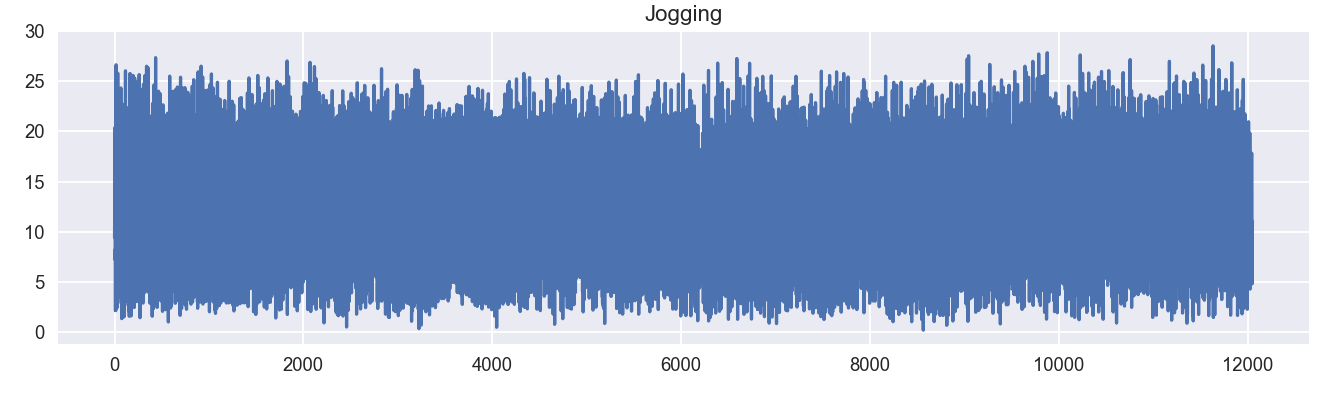

<IPython.core.display.Javascript object>


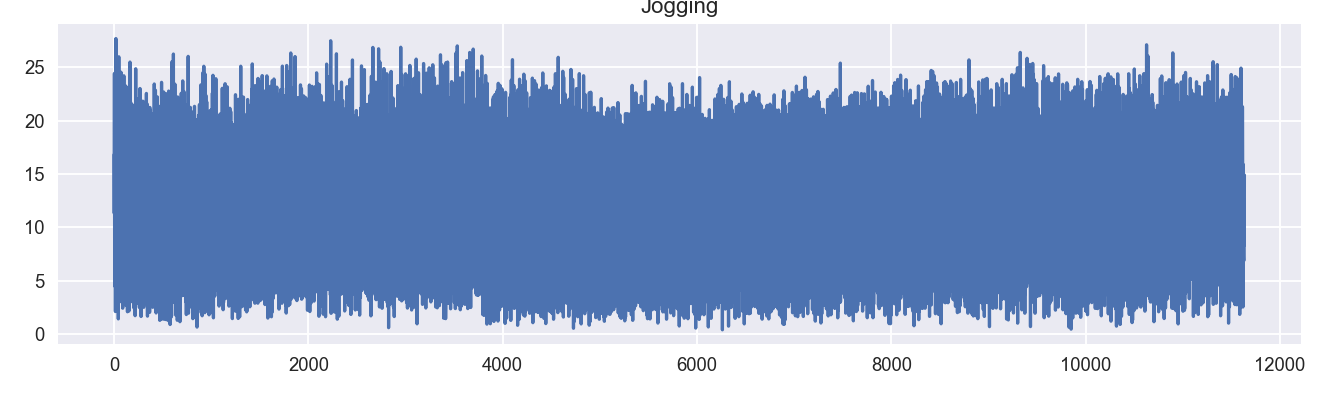

<IPython.core.display.Javascript object>


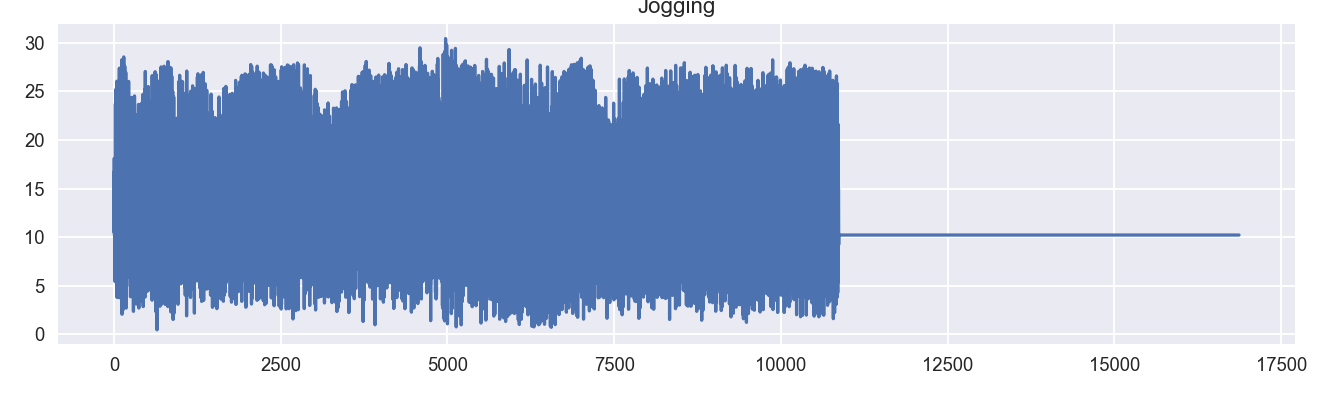

<IPython.core.display.Javascript object>


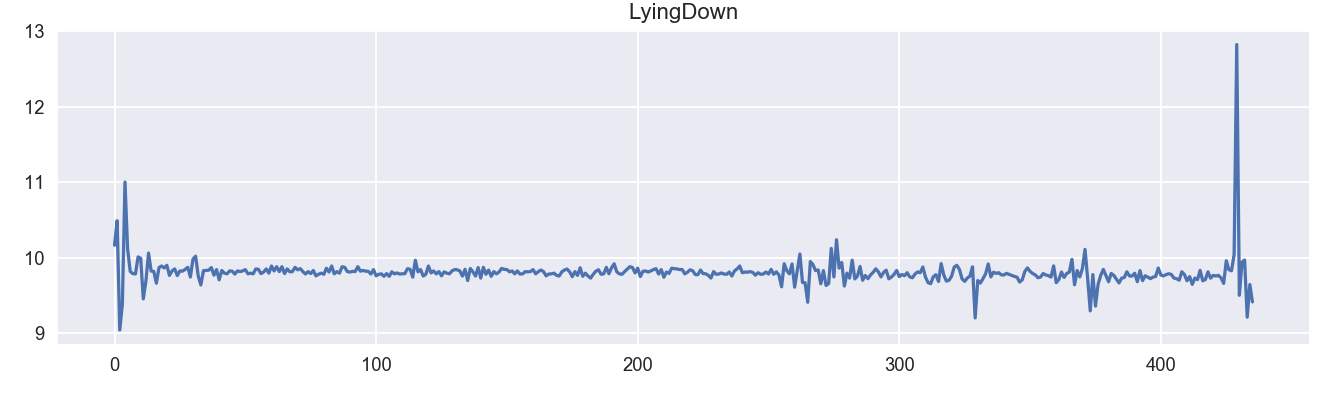

<IPython.core.display.Javascript object>


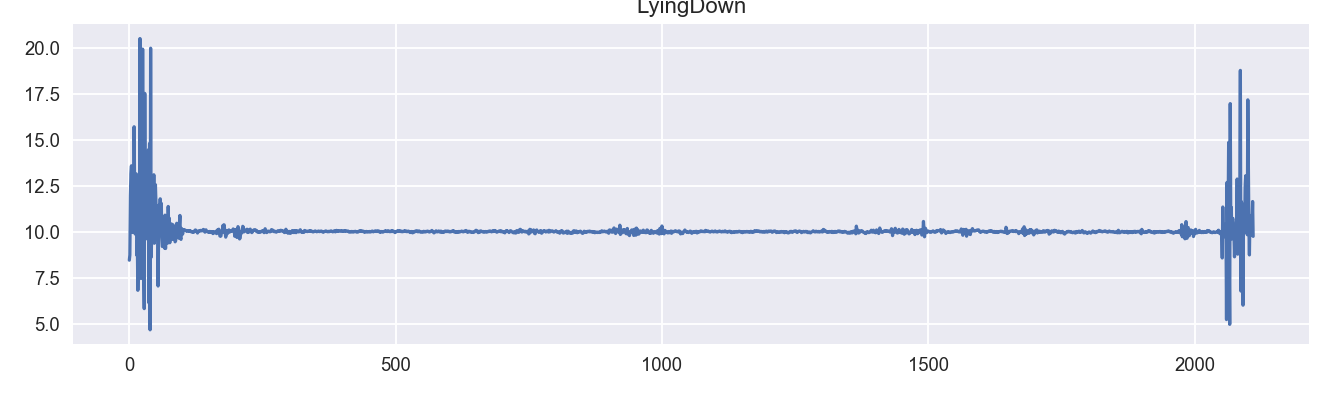

<IPython.core.display.Javascript object>


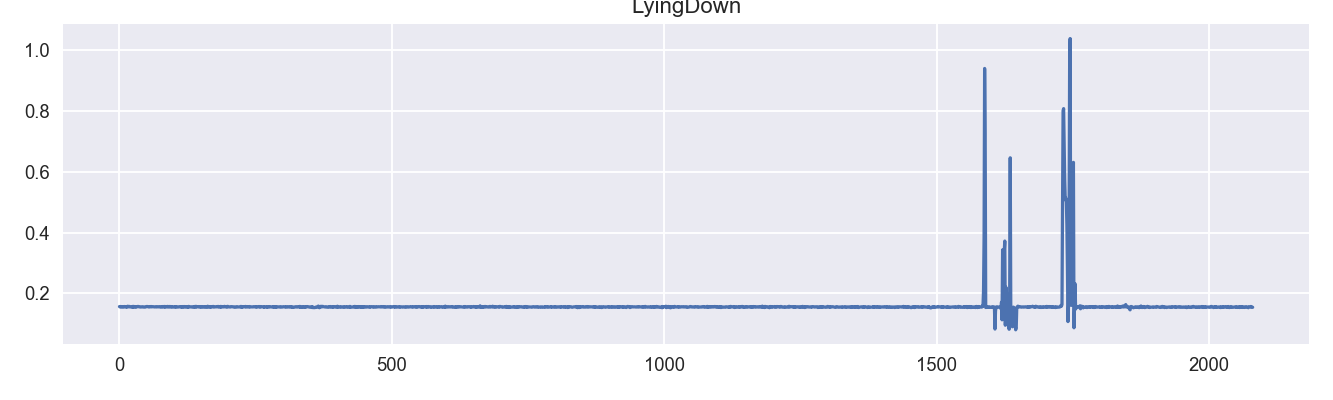

<IPython.core.display.Javascript object>


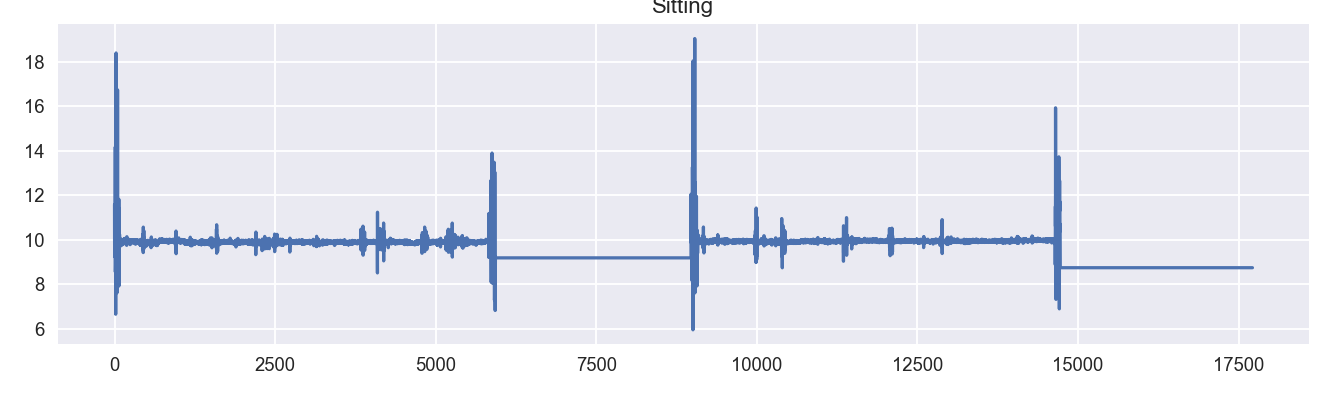

<IPython.core.display.Javascript object>


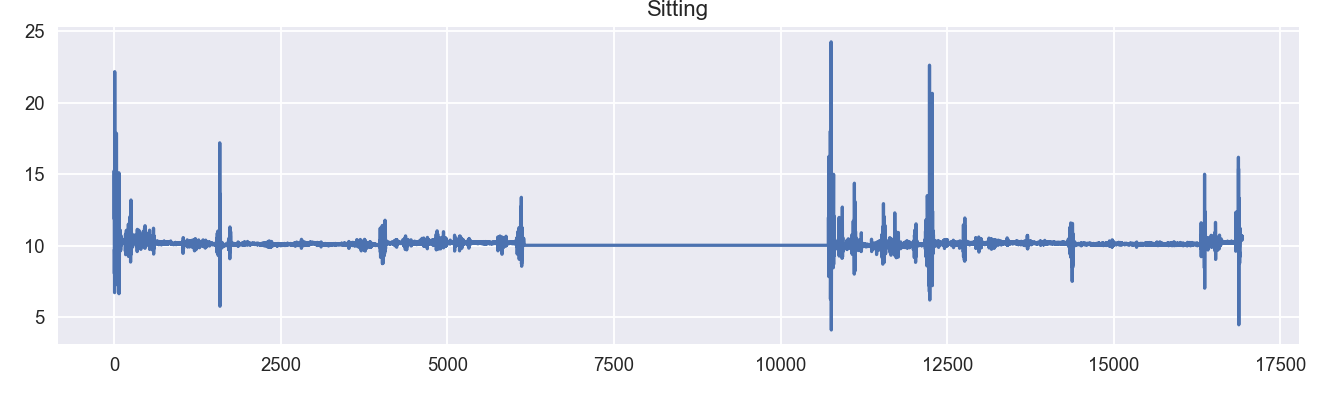

<IPython.core.display.Javascript object>


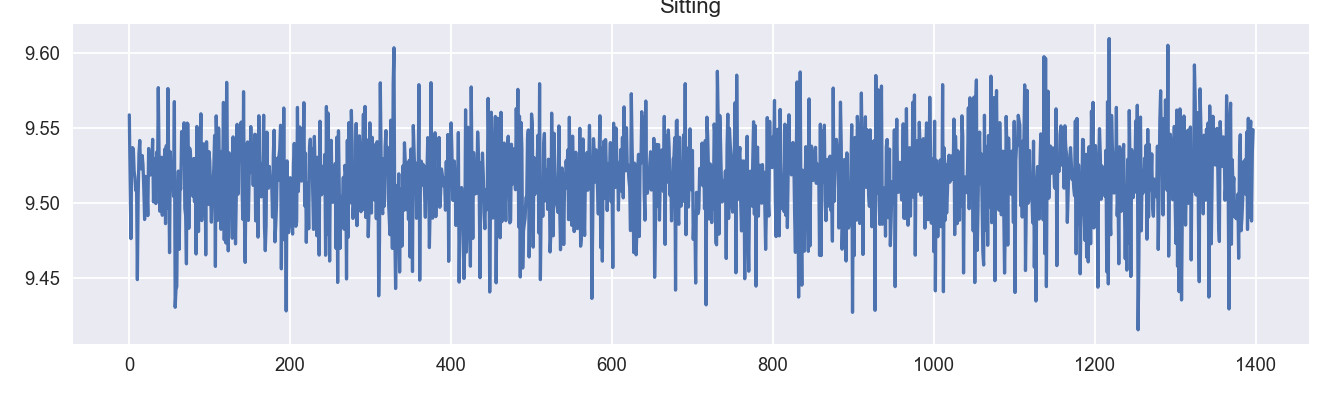

<IPython.core.display.Javascript object>


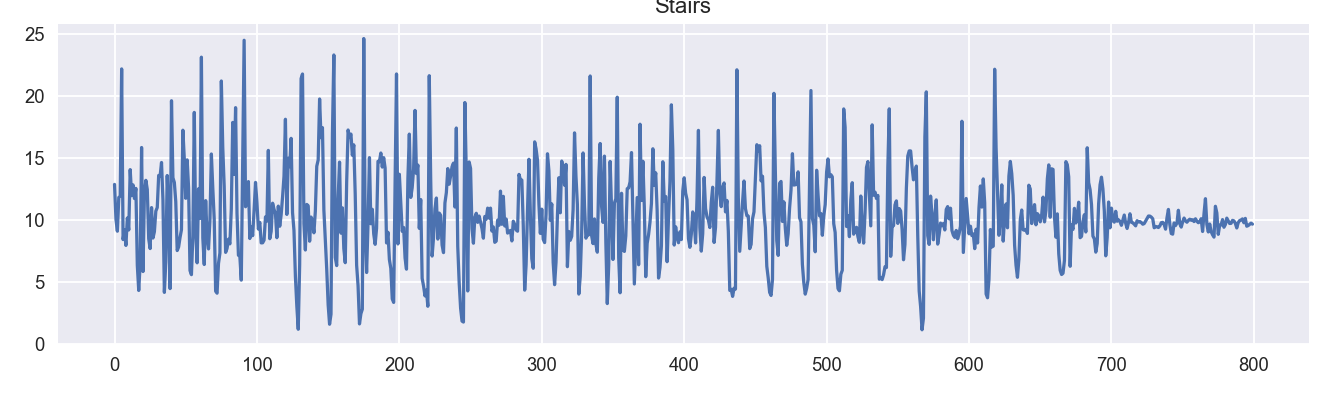

<IPython.core.display.Javascript object>


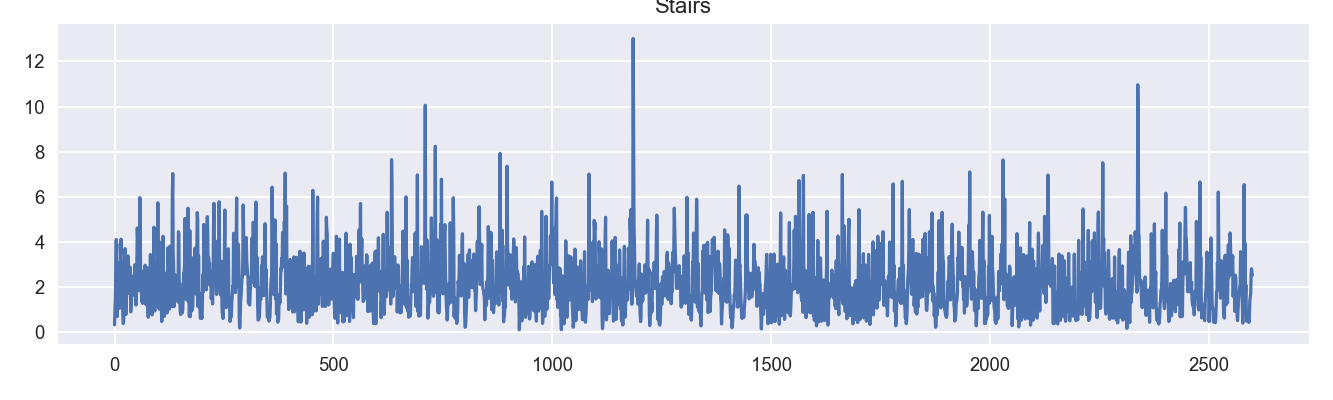

<IPython.core.display.Javascript object>


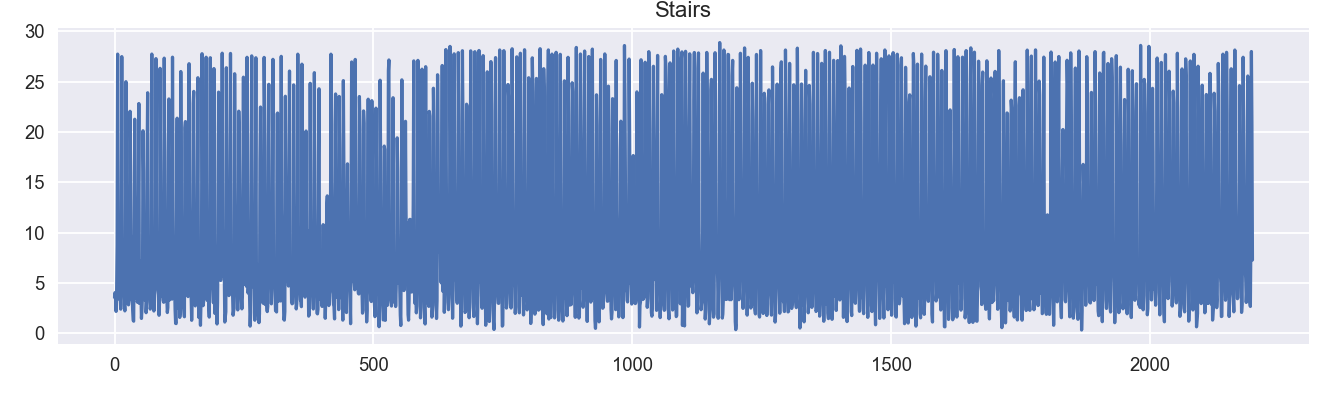

<IPython.core.display.Javascript object>


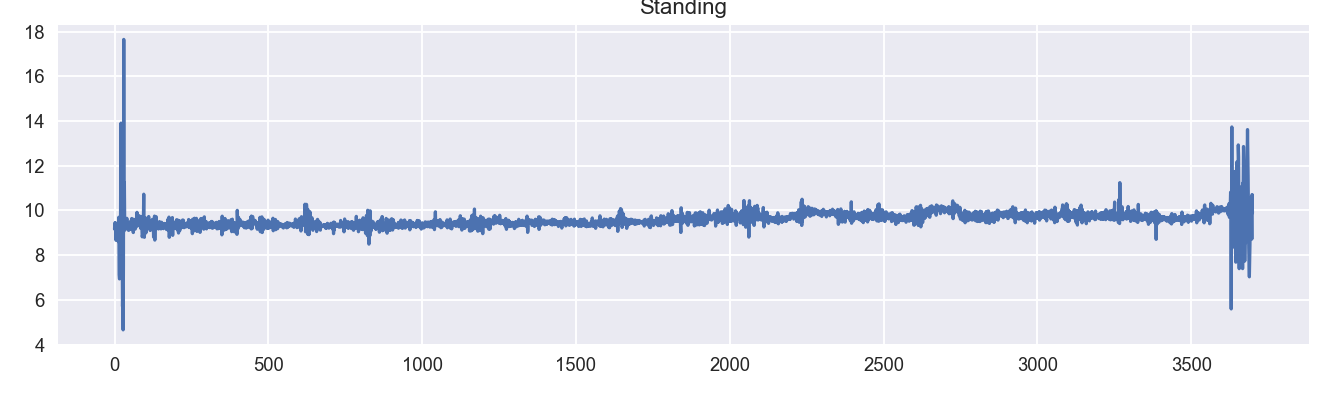

<IPython.core.display.Javascript object>


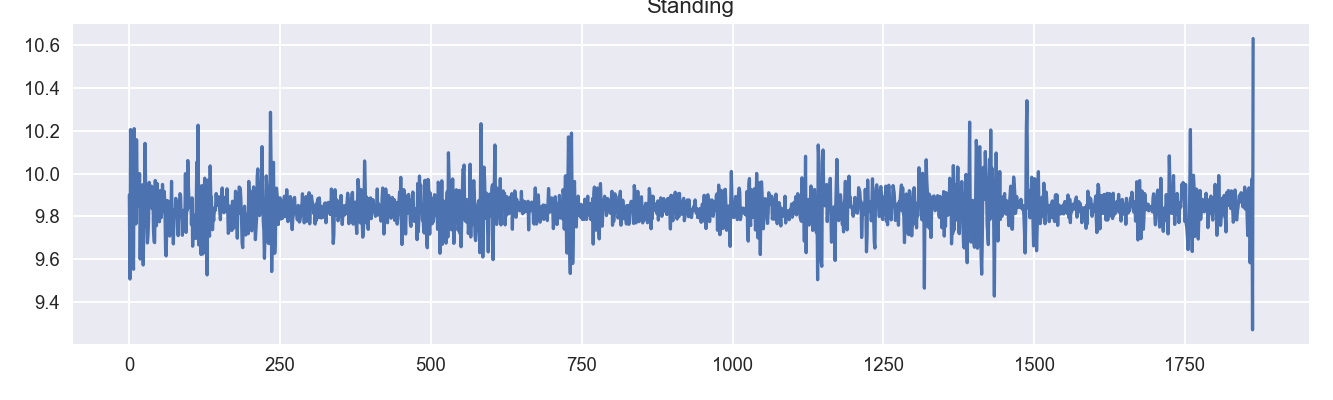

<IPython.core.display.Javascript object>


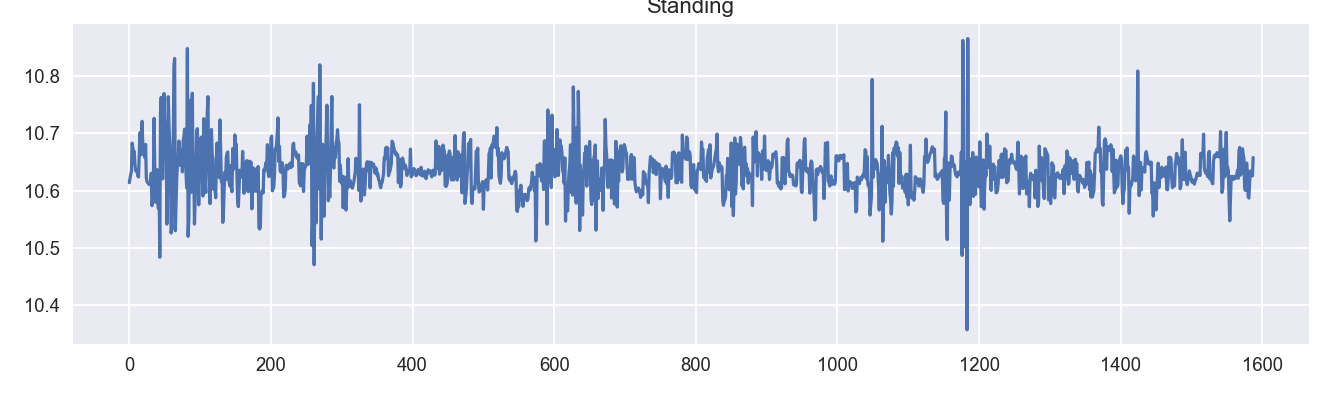

<IPython.core.display.Javascript object>


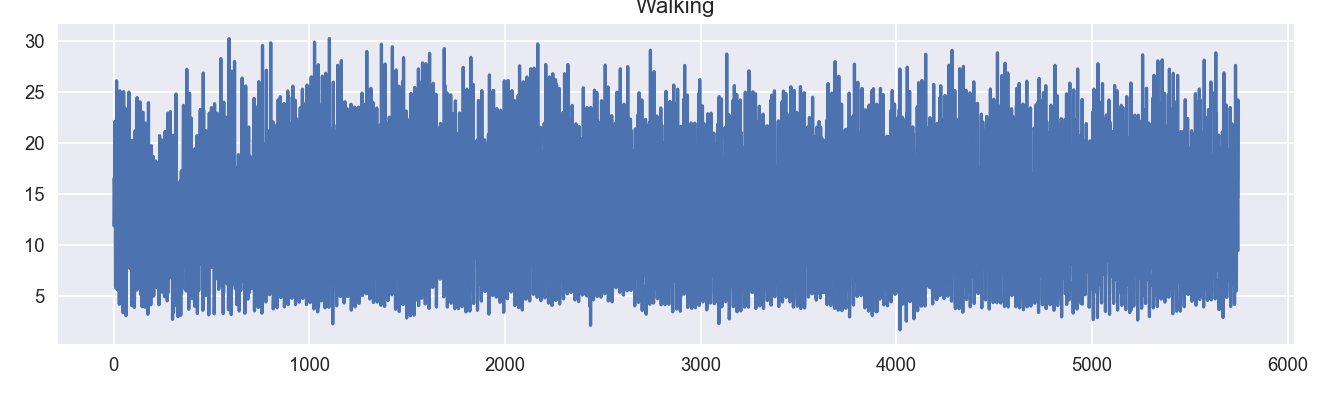

<IPython.core.display.Javascript object>


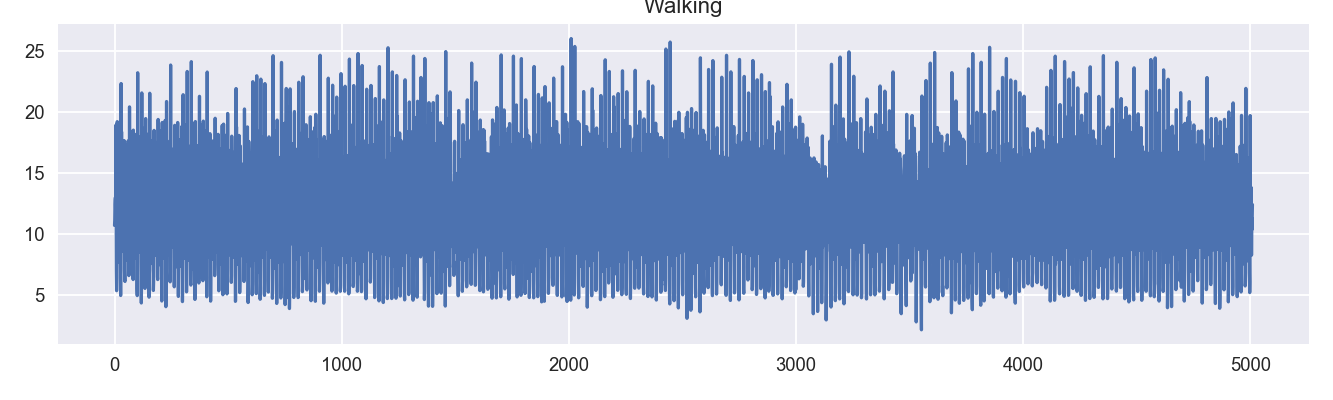

<IPython.core.display.Javascript object>


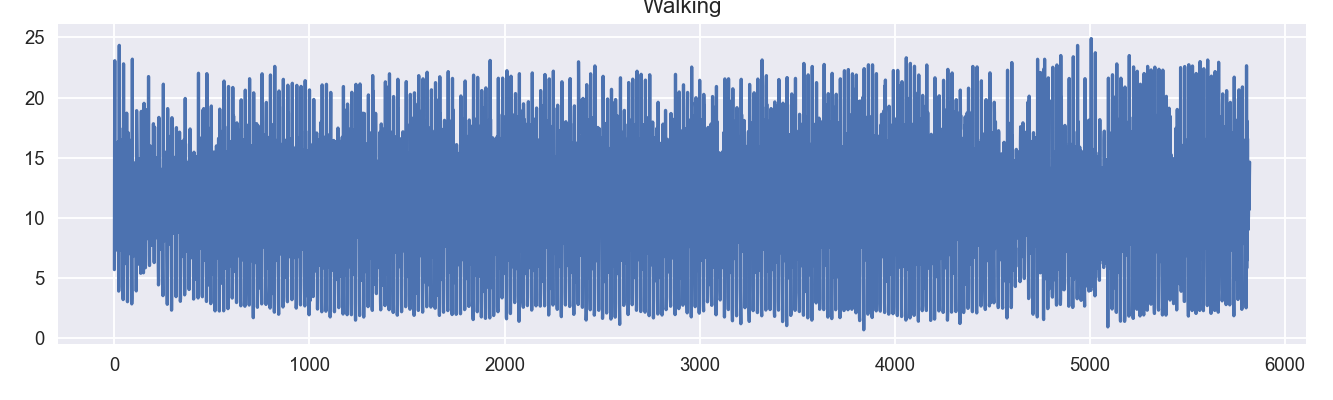

In [75]:
#plot some accelerometer clips
nsamp_per_act = 3
activities = raw_bysession["activity"].unique()

for act in activities:
    act_df = raw_bysession[raw_bysession["activity"]==act]
    users = act_df[act_df["activity"]==act]["user"]
    
    for j in np.random.choice(users, replace=False, size=nsamp_per_act):
        plt.figure(figsize=(10, 3))
        s = act_df[act_df["user"]==j]["tri-accel"]
        plt.plot(np.sqrt(np.sum(act_df[act_df["user"]==j]["tri-accel"].iloc[0]**2, axis=1)))
        plt.tight_layout()
        plt.title(act)

In [161]:
import pandas
import io
import re
relation = r'@relation (?P<relation>[^\n]+)'
attribute = r'@attribute (?P<attribute>[^\n]+)'
data = r'@data\n(?P<data>.+)'
arff_re = re.compile(r'{}|{}|{}'.format(relation, attribute, data), re.DOTALL)

def arff2dataframe(filename):
    with open(filename, 'r') as f:
        text = f.read()
    column_names = []
    for m in arff_re.finditer(text):
        d = m.groupdict()
        if d['attribute']:
            colm = re.match(r'\".+\"', d['attribute'])
            column_names.append(colm.group())
            #column_names.append(colm.group(1) or colm.group(2))
        if d['data']:
            csv_data = d['data']
    return pandas.read_csv(io.StringIO(csv_data),
                           header=None,
                           names=column_names)

In [162]:
trans_arff = arff2dataframe(base+"WISDM_at_v2.0_transformed.arff")

In [163]:
trans_arff

"user"  "X0"   "X1"   "X2"   "X3"  "X4"  "X5"  "X6"  "X7"  "X8"  "X9"  \
0        194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
1        194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
2        194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
3        194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
4        194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
5        194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
6        194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
7        194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
8        194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
9        194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
10       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
11       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
12       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
13       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
14       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
15       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
16       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
17       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
18       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
19       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
20       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
21       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
22       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
23       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
24       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
25       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
26       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
27       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
28       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
29       194   0.0  1.000  0.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
...      ...   ...    ...    ...    ...   ...   ...   ...   ...   ...   ...   
5405    1809   0.0  0.000  1.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
5406    1809   0.0  0.000  1.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
5407    1809   0.0  0.000  1.000  0.000  0.00   0.0   0.0   0.0   0.0   0.0   
5408    1809   0.0  0.145  0.850  0.005  0.00   0.0   0.0   0.0   0.0   0.0   
5409    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5410    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5411    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5412    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5413    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5414    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5415    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5416    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5417    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5418    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5419    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5420    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5421    1809   0.0  0.000  0.000  0.000  0.00   1.0   0.0   0.0   0.0   0.0   
5422    1813   0.0  0.000  0.000  0.450  0.55   0.0   0.0   0.0   0.0   0.0   
5423    1813   0.0  0.000  0.000  0.110  0.89   0.0   0.

In [150]:
unl_trans_arff = arff2dataframe(base+"WISDM_at_v2.0_unlabeled_transformed.arff")

In [151]:
unl_trans_arff

"user" {"194", "925", "995", "998", "1005", "1058", "1064", "1097", "1104", "1117", "1100", "1110", "1140", "1141", "1191", "1192", "1193", "1195", "1224", "1233", "1238", "1239", "1248", "1249", "1251", "1253", "1255", "1260", "1263", "1266", "1267", "1268", "1271", "1272", "1274", "1275", "1277", "1279", "1280", "1288", "1292", "1294", "1295", "1302", "1303", "1305", "1314", "1317", "1319", "1320", "1478", "1482", "1484", "1491", "1492", "1494", "1498", "1501", "1503", "1504", "1507", "1512", "1514", "1515", "1516", "1521", "1526", "1529", "1531", "1532", "1536", "1537", "1538", "1540", "1549", "1550", "1556", "1557", "1558", "1559", "1561", "1562", "1565", "1566", "1567", "1577", "1579", "1598", "1601", "1602", "1603", "1634", "1636", "1647", "1656", "1658", "1660", "1662", "1664", "1667", "1671", "1685", "1687", "1688", "1690", "1696", "1702", "1703", "1704", "1706", "1707", "1717", "1721", "1722", "1723", "1724", "1726", "1730", "1732", "1733", "1734", "1736", "1742", "1745", "1748", "1749", "1750", "1753", "1755", "1758", "1759", "1763", "1766", "1767", "1768", "1769", "1774", "1775", "1776", "1778", "1783", "1791", "1793", "1794", "1798", "1809", "1802", "1804", "1801"  \
0                                                      194                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1                                                      194                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2                                                      194                                                                                                                                                                                                                                                                                                                                          